In [1]:
try:
    import autograd.numpy as np
    from autograd import grad
except:
    print('Please make sure you installed autograd package!')

In [2]:
import numpy as tnp
from sklearn.datasets import make_moons

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.stats import norm
from scipy.stats import multivariate_normal as mnorm
from scipy.stats import kde
from tqdm import tqdm_notebook
from scipy.optimize import minimize

In [5]:
x, y = make_moons(2000, noise=0.1, shuffle=False)

x2,y2 = make_moons(2000, noise=0.1, shuffle=False)
x2 = x2[y2==0]
y2 = y2[y2==0]
y2 = y2+2
x2 = x2*2.5
x2[:,0] = x2[:,0]+0.5


x = tnp.concatenate([x,x2], axis=0)

y = tnp.concatenate([y,y2])

In [8]:
x.shape

(3000, 2)

In [6]:
colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'gray'}
cmaps = ['Reds', 'Greens', 'Blues', 'Greys']
clabels = [colors[l] for l in y]

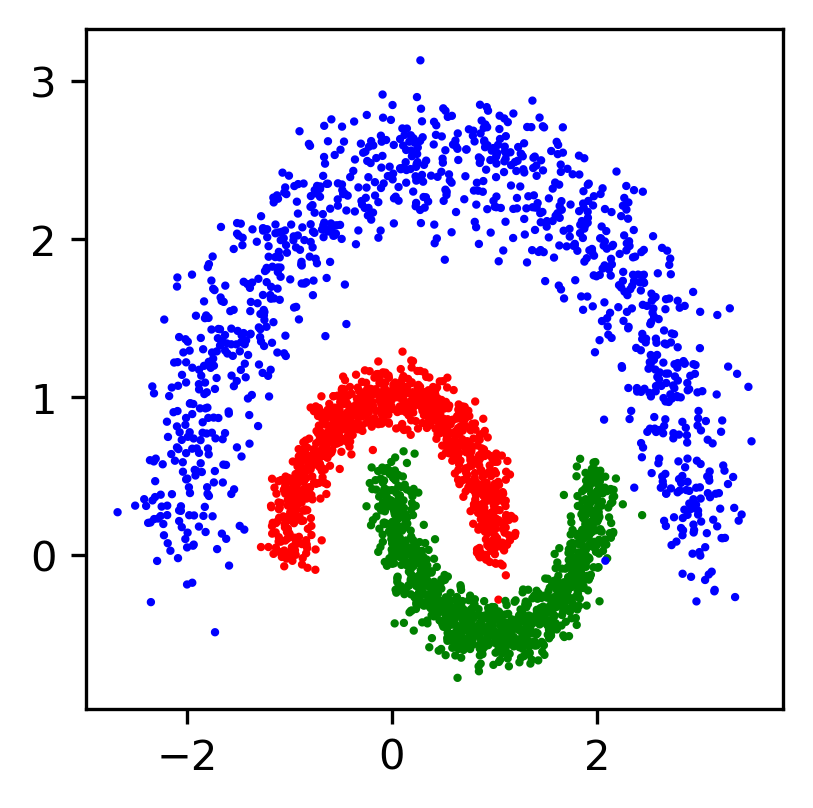

In [7]:
f = plt.figure(figsize=(3,3), dpi=300)
plt.scatter(x[:,0], x[:,1], s=1, c=clabels)

In [9]:
def one_hot(arr):
    classes = np.unique(y)
    num_classes = len(classes)
    return classes,np.squeeze(np.eye(num_classes)[arr.reshape(-1)])

In [10]:
classes,y_oh = one_hot(y)

In [11]:
y_oh

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [12]:
def softmax(z):
    # z ~ N x C3
    
    z_clipped = z-z.max()
    log_softmax = z_clipped - np.log(np.sum(np.exp(z_clipped), axis=-1, keepdims=True))
    softmax_values = np.exp(log_softmax)
    return softmax_values

In [13]:
def sigmoid(z):
    # YOUR CODE HERE
    # you need to implement sigmoid function of z
    # the resulting matrix should be assigned to the "result" variable
    
    result = 1/(1 + np.exp(-z))
    
    return result

In [14]:
def relu(z):
    # YOUR CODE HERE
    # you need to implement ReLU function of z
    # the resulting matrix should be assigned to the "result" variable
    
    result = np.maximum(0.0, z)
    
    return result

In [15]:
def compute_probabilities(X, theta):
    p = None
    
    # YOUR CODE HERE
    # you need to implement the neural network that computes the estimates of probabilities
    # for each object of X for each class

    # note that the size of p should be NxK
    # where
    # N is the number of objects in X
    # K is the number of classes of the problem
    
    # (1) you need to get chunks of theta values out of theta of reasonable lengths
    #     and reshape them into the correct theta matrices for each ANN layer
    # (2) you need to implement layers themselves,
    #     which includes matrix multiplication and the application of a non-linearity function
    #     (sigmoid, ReLU of softmax)
    #     make sure you did not forget biases for each layer
    
    # p ~ N x C3
    # C3 = 3
    
    f = X.shape[1]
    C1 = 6
    C2 = 4
    C3 = 3
    
    curr_start_idx = 0
    t1_star = theta[curr_start_idx : curr_start_idx + (f+1)*C1 ]
    curr_start_idx = curr_start_idx + (f+1)*C1
    t1_star = np.reshape(t1_star, ((f+1), C1)) # (f+1) x C1
    
    t2_star = theta[curr_start_idx : curr_start_idx + (C1+1)*C2 ]
    curr_start_idx = curr_start_idx + (C1+1)*C2
    t2_star = np.reshape(t2_star, ((C1+1), C2)) # (C1+1) x C2
    
    t3_star = theta[curr_start_idx : curr_start_idx + (C2+1)*C3 ]
    curr_start_idx = curr_start_idx + (C2+1)*C3
    t3_star = np.reshape(t3_star, ((C2+1), C3)) # (C2+1) x C3
    
    
    X_0 = np.ones((X.shape[0], 1), dtype=np.float) # N x 1
    X_biased = np.concatenate([X_0, X], axis=1)    # N x (f+1)
    z1 = np.dot(X_biased, t1_star)                 # N x (f+1) dot (f+1) x C1
    a1 = sigmoid(z1)                               # N x C1
    
    a1_0 = np.ones((a1.shape[0], 1), dtype=np.float) # N x 1
    a1_biased = np.concatenate([a1_0, a1], axis=1)   # N x (C1+1)
    z2 = np.dot(a1_biased, t2_star)                  # N x C2
    a2 = sigmoid(z2)                                 # N x C2
    
    a2_0 = np.ones((a2.shape[0], 1), dtype=np.float) # N x 1
    a2_biased = np.concatenate([a2_0, a2], axis=1)   # N x (C2+1)
    z3 = np.dot(a2_biased, t3_star)                  # N x C3
    p  = softmax(z3)                                 # N x C3
    
    return p

In [16]:
def multinomial_cross_entropy(p_pred, y_true):
    return -np.sum(np.multiply(y_true, np.log(p_pred)), axis=-1, keepdims=True)

In [17]:
def multinomial_cross_entropy_loss(X, y, theta, reg_alpha = 1.0e-3):
    # YOUR CODE HERE
        
    p = compute_probabilities(X, theta)
    l = multinomial_cross_entropy(p, y)
    
    l_reg = np.sum(np.square(theta))
    # YOUR ADDITIONAL CODE HERE
    # you need to implement the regularization L2 penalty term
    # that helps to limit the values of parameters theta of the model
    
    return np.squeeze(np.mean(l, axis=0, keepdims=True)) + reg_alpha * l_reg

In [19]:
# YOUR CODE HERE
# you need to generate random theta values according to:
#          - the number of features of input data X
#          - the number of nodes in each layer, and the bias term
#          - the number of output nodes (the number of classes K)
# Then you need to flatten these matrices and and concatenate them into one vector
# (due to the specifics of the function "minimize" of scipy package)
#
# assign the vector of theta values to the vatiable theta_start

f = x.shape[1]
C1 = 6
C2 = 4
C3 = 3
n_theta = (f+1)*C1 + (C1+1)*C2 + (C2+1)*C3

theta_start = np.random.randn(n_theta)

In [22]:
theta_start

array([-0.3783023 , -0.89185832,  1.0406009 ,  2.42440419, -0.09952825,
       -0.94690256, -0.29819999,  1.04007373, -0.24089722, -0.39530708,
       -1.11172724,  0.8870659 ,  0.18811234, -0.35002771, -1.15130395,
       -1.69218895,  0.68949005,  0.20367893,  1.0391811 ,  0.97941179,
        1.03785049,  1.10736848,  0.17226474,  0.32491184, -1.59285745,
        1.4608782 ,  1.28022408, -1.51966834, -0.34297144,  2.32733698,
       -0.28698283,  0.2005877 ,  0.09877844, -0.92972725, -1.96659561,
        0.12544341, -0.36990986,  1.12324061,  1.09271465,  0.16187287,
       -0.89981024, -0.87402707,  1.00907211, -2.21437001,  0.23526508,
        1.58608326,  1.02249561, -3.21474427,  0.7476115 ,  0.42202584,
        0.8626382 , -2.17232679,  1.12496805, -2.04757599,  0.57690203,
       -0.49265343, -0.32481241,  1.14952234, -0.34550802,  0.37413437,
       -0.22252175])

### Here we are starting to optimize the model we have just created

In [23]:
loss_fn = multinomial_cross_entropy_loss

In [24]:
grad_fn = grad(loss_fn, argnum=2)

In [25]:
curr_loss = loss_fn(x,y_oh,theta_start)

In [26]:
curr_loss

2.381199936606996

In [27]:
curr_loss_grad = grad_fn(x,y_oh,theta_start)
curr_loss_grad

array([ 3.81735829e-02, -9.56437446e-02,  1.26600312e-02,  4.46609650e-03,
        1.65046638e-03, -1.33205068e-01,  2.09695423e-02, -7.50565451e-02,
        1.25474106e-02,  2.06518512e-02,  1.30399983e-03, -1.18645989e-01,
        6.84909799e-02,  3.02855566e-02, -9.49733444e-03, -2.95283202e-02,
        3.72535204e-02,  1.41295582e-02, -1.49768391e-02,  2.36540666e-01,
       -6.69775157e-02, -5.93425184e-03,  5.56543079e-03,  8.32419179e-02,
       -3.60973436e-02, -4.32878528e-04, -2.28638906e-02,  1.14656151e-01,
       -2.54523011e-02,  1.74129787e-03, -3.81437459e-02,  1.60520357e-01,
       -6.87738478e-03, -7.00295292e-03, -4.98486009e-02,  1.98429399e-01,
       -8.99242969e-03, -4.17680864e-03,  2.82673067e-02,  6.99358815e-02,
       -4.75121441e-02, -5.55487506e-03, -1.12185961e-02,  1.02563354e-01,
       -3.80058324e-02,  2.71551662e-04,  4.81028266e-01, -3.29958503e-01,
       -1.53959037e-01,  3.60298500e-01, -2.03398390e-01, -1.58675435e-01,
        1.98295323e-01, -

In [28]:
# this is just a callback that runs each iteration of the minimization loop
# we are just logging the loss history here

def minimization_callback(loss_history, curr_loss_value):
    loss_history.append(curr_loss_value)
    print('loss_value: %f' % curr_loss_value)

In [29]:
# actual minimization of the loss function of out model

loss_history = []
optimization_result = minimize(lambda t: float(loss_fn(x, y_oh, t)),
                               theta_start,
                               jac = lambda t: np.array(grad_fn(x, y_oh, t)).flatten(),
                               callback = lambda t: minimization_callback(loss_history, float(loss_fn(x,y_oh,t))))

loss_value: 1.583758
loss_value: 1.301380
loss_value: 1.137054
loss_value: 1.108189
loss_value: 1.064778
loss_value: 1.011155
loss_value: 0.921215
loss_value: 0.848902
loss_value: 0.830168
loss_value: 0.805999
loss_value: 0.769383
loss_value: 0.739681
loss_value: 0.730409
loss_value: 0.719279
loss_value: 0.700737
loss_value: 0.675978
loss_value: 0.666201
loss_value: 0.662277
loss_value: 0.658538
loss_value: 0.652714
loss_value: 0.644522
loss_value: 0.636132
loss_value: 0.627403
loss_value: 0.623946
loss_value: 0.622802
loss_value: 0.621468
loss_value: 0.619306
loss_value: 0.616153
loss_value: 0.613446
loss_value: 0.611289
loss_value: 0.609679
loss_value: 0.607868
loss_value: 0.604797
loss_value: 0.599309
loss_value: 0.590258
loss_value: 0.588173
loss_value: 0.584657
loss_value: 0.580527
loss_value: 0.579220
loss_value: 0.577096
loss_value: 0.573653
loss_value: 0.568215
loss_value: 0.559957
loss_value: 0.549692
loss_value: 0.542517
loss_value: 0.538494
loss_value: 0.534240
loss_value: 0

loss_value: 0.399940
loss_value: 0.399940
loss_value: 0.399940
loss_value: 0.399940
loss_value: 0.399940
loss_value: 0.399940


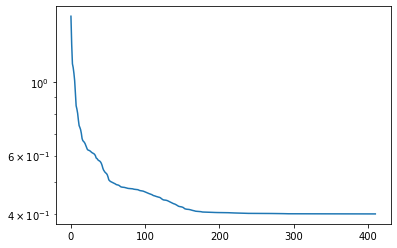

In [30]:
# let us plot the loss function evolution

plt.plot(loss_history)
plt.yscale('log')

In [31]:
# here we will get the theta values from the optimization result

theta_result = optimization_result.x

In [32]:
theta_result

array([-0.36678955, -1.65370498,  2.17886893,  3.43362765, -2.45180266,
       -1.99379485,  0.66278145, -1.28252597, -3.99464893, -1.48793419,
       -2.43865054,  1.5191975 , -1.98510302,  1.72152095, -1.67288152,
       -1.55198122,  0.84663463, -1.225521  , -0.86197663,  0.97927592,
        0.26805659, -0.2354563 ,  1.91469873, -1.55680476, -0.02947906,
        0.01143871, -1.89240483,  1.67462884,  2.15562636, -1.99144217,
        2.64250023, -2.05371924, -0.53457411,  0.49383348, -1.19373222,
        0.35816972, -3.38691362,  3.13163954, -2.0499826 ,  1.69768389,
        2.84227629, -2.61674548,  1.92161908, -1.23858178,  1.42777245,
       -1.34539572,  0.01777251, -0.26237892,  0.24424153, -3.29282573,
        3.48215855, -0.18955701,  2.24902313, -3.12823204,  0.8791216 ,
       -2.59998863, -2.05043621,  4.6505087 ,  2.4120146 ,  1.70118756,
       -4.11325114])

In [33]:
# computing probabilities using the optimized ANN weights and
# its architecture described in the function compute_probabilities()

pred_proba = compute_probabilities(x, theta_result)
print(pred_proba.shape)

(3000, 3)


In [34]:
# transforming the probabilities into the class labels

y_pred = classes[np.argmax(pred_proba, axis=1)]

In [35]:
y_pred

array([1, 1, 1, ..., 2, 0, 0])

In [36]:
# calculating the accuraacy score

np.mean(y_pred == y)

0.971

### Let us plot the resulting probabilities for the classes

In [37]:
nbins = 400
xmesh, ymesh = tnp.mgrid[-4:4:nbins*1j, -4:4:nbins*1j]

In [38]:
x_test_mesh = np.concatenate([xmesh.ravel()[:,np.newaxis], ymesh.ravel()[:,np.newaxis]], axis=-1)
x_test_mesh.shape

(160000, 2)

In [40]:
probas_mesh = compute_probabilities(x_test_mesh, theta_result)

In [41]:
preds_mesh = classes[np.argmax(probas_mesh, axis=1)]

In [42]:
probas_mesh = probas_mesh.reshape(list(xmesh.shape) + [3])

In [43]:
preds_mesh = preds_mesh.reshape(xmesh.shape)

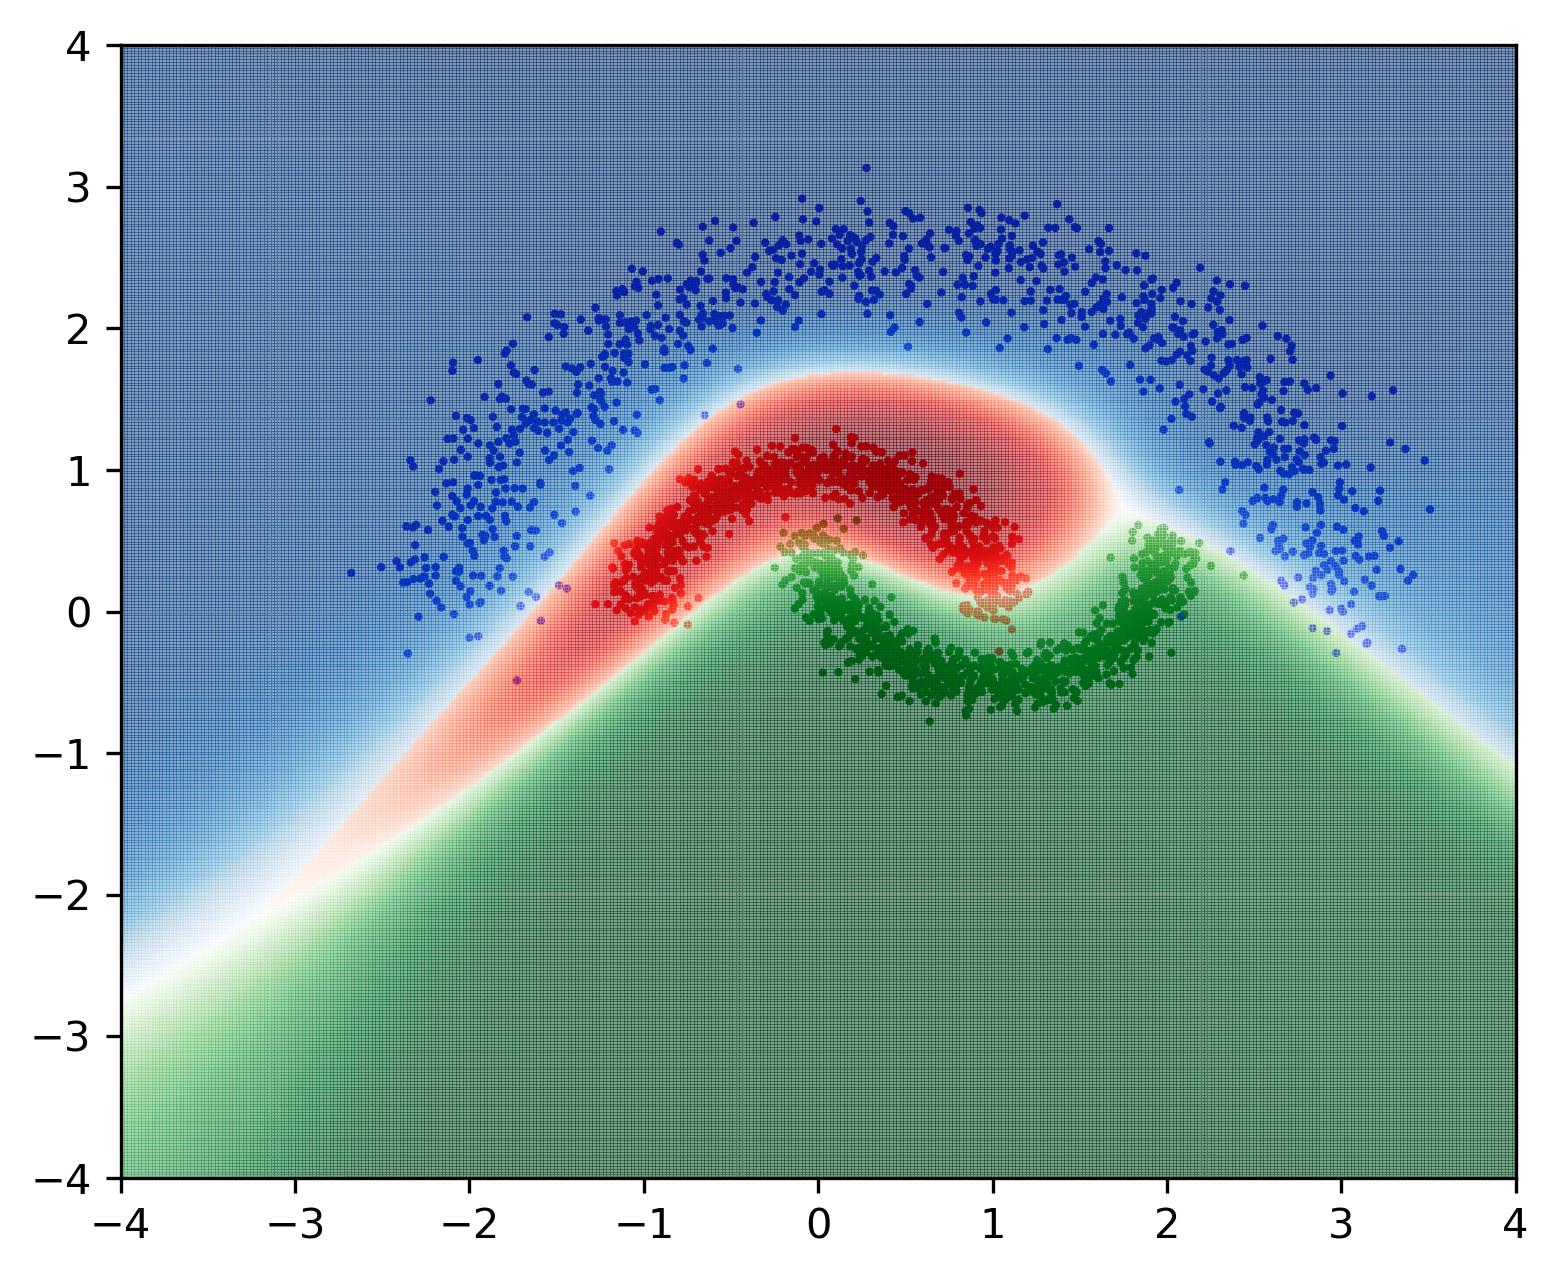

In [44]:
_ = plt.figure(figsize=(6,5), dpi=300)
plt.scatter(x[:,0], x[:,1], s=1, c=clabels)
for class_label,proba_mesh in zip([0,1,2], [probas_mesh[:,:,0], probas_mesh[:,:,1], probas_mesh[:,:,2]]):
    pm = tnp.ma.array(proba_mesh)
    pm.mask = (preds_mesh != class_label)
    _ = plt.pcolormesh(xmesh, ymesh, pm, cmap=cmaps[class_label], alpha=0.5)

In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
LR = LogisticRegression()
LR.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
LR_preds = LR.predict(x)

In [48]:
# calculating the accuraacy score

np.mean(LR_preds == y)

0.806

In [49]:
LR_probas_mesh = LR.predict_proba(x_test_mesh)

In [51]:
LR_probas_mesh.shape

(160000, 3)

In [52]:
LR_preds_mesh = classes[np.argmax(LR_probas_mesh, axis=1)]

In [53]:
LR_probas_mesh = LR_probas_mesh.reshape(list(xmesh.shape) + [3])

In [54]:
LR_preds_mesh = LR_preds_mesh.reshape(xmesh.shape)

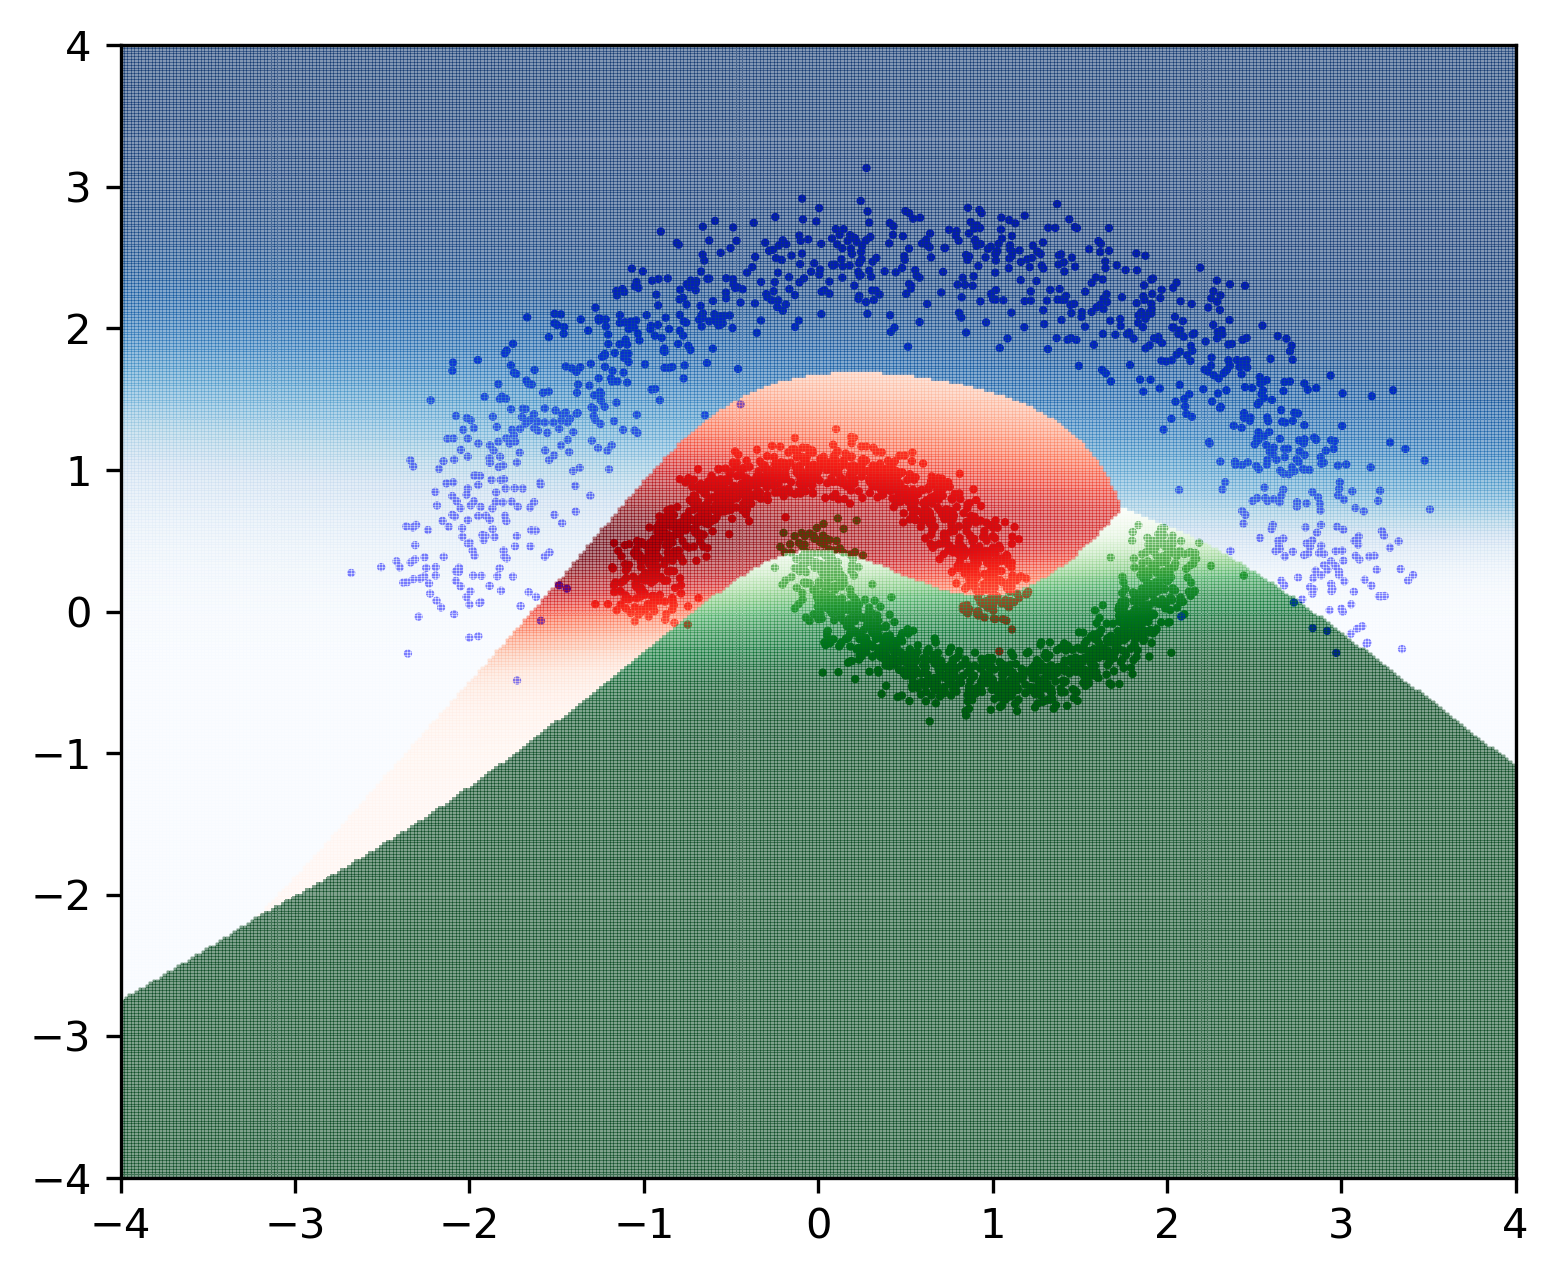

In [55]:
_ = plt.figure(figsize=(6,5), dpi=300)
plt.scatter(x[:,0], x[:,1], s=1, c=clabels)
for class_label,proba_mesh in zip([0,1,2], [LR_probas_mesh[:,:,0], LR_probas_mesh[:,:,1], LR_probas_mesh[:,:,2]]):
    pm = tnp.ma.array(proba_mesh)
    pm.mask = (preds_mesh != class_label)
    _ = plt.pcolormesh(xmesh, ymesh, pm, cmap=cmaps[class_label], alpha=0.5)